# RNN of an Auto-Regressive Process

In [1]:
# data wrangling
import pandas as pd 
import numpy as np 

# pytorch framework
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils

# pytorch-lightning framework
import pytorch_lightning as pl

# data viz
import matplotlib.pyplot as plt
import seaborn as sns

# utils
import os

# Data wrangling

## Generating and Preparing Data

<AxesSubplot:xlabel='n', ylabel='y'>

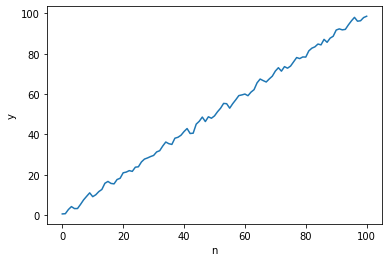

In [10]:
n = 101
rng = np.random.default_rng()
x = np.sin(range(n))
white_noise = rng.normal(0,1, n)

def ar1_seq(original_seq, coef, noise):
    """ Create a autoregressive of 1 step given an original sequence.
    y[n] = coef*y[n-1] + noise.

    returns: numpy.array
    """
    y = []
    for index, value in enumerate(original_seq):
        new_value =  value + coef*x[index - 1]
        y.append(new_value)

    y = np.array(y) + noise

    return(y)


y = ar1_seq(x, 0.5, white_noise)
y = np.arange(y.shape[0]) + y

# Check plotting data
df = pd.DataFrame({
    'y': y,
    'n': range(n)
})

sns.lineplot(data=df, x='n', y='y')

## building dataloaders

In [31]:
class ToTensor(object):
    def __call__(self, sample):
        return {
            'x': torch.from_numpy(sample['x']).float(),
            'y': torch.from_numpy(sample['y']).float()
        }


class SequenceData(Dataset):
    def __init__(self, y:np.array, transform=None, k:int=1):
        
        self.y = y.copy()
        self.transform = transform
        self.k = k
    
    def __len__(self):
        return len(self.y)-self.k
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        k = self.k
        
        sample = {}

        sample['y'] = self.y[[idx+k]]
        sample['x'] = self.y[(idx):(idx+k)]

        if self.transform:
            sample = self.transform(sample)
        
        return sample
        
K = 3
seq_dataset = SequenceData(
    y = df['y'].to_numpy(),
    transform=ToTensor(),
    k = K
)

for index, i in enumerate(seq_dataset):
    y, x = i['y'], i['x']
    print(df.iloc[index:(index + K + 1)])
    print(x, y)
    if index == 2:
        break

          y  n
0  0.543492  0
1  0.649220  1
2  2.709189  2
3  4.175440  3
tensor([0.5435, 0.6492, 2.7092]) tensor([4.1754])
          y  n
1  0.649220  1
2  2.709189  2
3  4.175440  3
4  3.186770  4
tensor([0.6492, 2.7092, 4.1754]) tensor([3.1868])
          y  n
2  2.709189  2
3  4.175440  3
4  3.186770  4
5  3.209380  5
tensor([2.7092, 4.1754, 3.1868]) tensor([3.2094])


In [26]:
len(seq_dataset)

98

In [32]:
train_n = int(len(seq_dataset) * 0.8)
test_n = len(seq_dataset) - train_n

train_dataset, val_dataset = random_split(seq_dataset, lengths=[train_n, test_n])
print(len(train_dataset), len(val_dataset))

dataset_dict = {
    'train': train_dataset,
    'val': val_dataset
}

78 20


In [39]:
def pad_collate(batch):
    print(batch)

seq_dataloader = DataLoader(
    dataset_dict['train'],
    batch_size=10,
    num_workers=os.cpu_count(),
    collate_fn=pad_collate
)

for index, i in enumerate(seq_dataloader):
    y, x = i['y'], i['x']
    # print(df.iloc[index:(index + K + 1)])
    print(x, y)
    print(x.shape, y.shape)
    if index == 2:
        break

[{'x': tensor([18.2250, 20.9351, 21.2813]), 'y': tensor([22.0110])}, {'x': tensor([59.2256, 59.5687, 59.9932]), 'y': tensor([59.1751])}, {'x': tensor([3.1868, 3.2094, 5.2852]), 'y': tensor([7.5151])}, {'x': tensor([88.6560, 91.7475, 92.3097]), 'y': tensor([91.8328])}, {'x': tensor([67.4362, 66.6622, 65.9707]), 'y': tensor([67.4885])}, {'x': tensor([ 9.2789, 10.9864,  9.0994]), 'y': tensor([10.0315])}, {'x': tensor([83.4104, 84.7990, 84.3844]), 'y': tensor([87.1164])}, {'x': tensor([46.3513, 48.7150, 47.9963]), 'y': tensor([49.1482])}, {'x': tensor([5.2852, 7.5151, 9.2789]), 'y': tensor([10.9864])}, {'x': tensor([17.6049, 18.2250, 20.9351]), 'y': tensor([21.2813])}][{'x': tensor([46.4879, 48.5747, 46.3513]), 'y': tensor([48.7150])}, {'x': tensor([87.1164, 85.6650, 87.7189]), 'y': tensor([88.6560])}, {'x': tensor([59.5687, 59.9932, 59.1751]), 'y': tensor([60.9490])}, {'x': tensor([0.5435, 0.6492, 2.7092]), 'y': tensor([4.1754])}, {'x': tensor([47.9963, 49.1482, 51.2105]), 'y': tensor([52

TypeError: 'NoneType' object is not subscriptable

# Modelling

In [8]:
class RNN(pl.LightningModule):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, dataset_dict):
        super(RNN, self).__init__()

        self.dataset_dict = dataset_dict

        self.criterion = nn.MSELoss()

        self.hidden_dim=hidden_dim
        self.n_layers = n_layers
        self.hidden = None

        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # rnn_out_raw (batch_size, time_step, hidden_size)
        # rnn_out (batch_size * seq_length, hidden_size)

        x = x.unsqueeze(-1)

        rnn_out_raw, hidden = self.rnn(x, self.hidden)
        print(rnn_out_raw)
        
        # final output transformation
        rnn_out = rnn_out_raw.view(-1, self.hidden_dim)
        output = self.fc(rnn_out)
        
        return output, hidden
    
    def training_step(self, batch, batch_idx):
        x, y = batch['x'], batch['y']

        y_hat, self.hidden = self(x)

        self.hidden = self.hidden.data

        loss = self.criterion(y, y_hat)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        return optimizer
    
    def train_dataloader(self):
        return DataLoader(self.dataset_dict['train'], batch_size=10, num_workers=os.cpu_count())
    
    # def val_dataloader(self):
    #     return DataLoader(self.dataset_dict['val'], batch_size=10, num_workers=os.cpu_count())

model = RNN(
    input_size=1,
    output_size=1,
    hidden_dim=2,
    n_layers=1,
    dataset_dict=dataset_dict
    
)

trainer = pl.Trainer(
    default_root_dir='../',
    #log_every_n_steps=5,
    max_epochs=30,
    enable_progress_bar=True
)

trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | rnn       | RNN     | 10    
2 | fc        | Linear  | 3     
--------------------------------------
13        Trainable params
0         Non-trainable params
13        Total params
0.000     Total estimated model params size (MB)


Epoch 29: 100%|██████████| 80/80 [00:01<00:00, 73.21it/s, loss=1.75, v_num=3] 


In [ ]:
x = 